<a href="https://colab.research.google.com/github/drprajapati/APTOS-2019-Blindness-Detection/blob/master/APTOS_Blindness_Detection_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install -q kaggle
# !pip install -q kaggle-cli

In [0]:
# from google.colab import files

# #retrieve uploaded file
# uploaded = files.upload()

In [0]:
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !ls ~/.kaggle

In [0]:
# #@title Verify Content of the `kaggle.json` file
# # Verify json content
# verify_content = True #@param {type: "boolean"}

# !ls -l ~/.kaggle
# !cat ~/.kaggle/kaggle.json

In [0]:
# !kaggle competitions download -c aptos2019-blindness-detection

In [0]:
# import os
# for dirname, _, filenames in os.walk('/content'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# print(os.getcwd())

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !mv './sample_submission.csv' './drive/My Drive/Kaggle/APTOS/data/'
# !mv './test.csv' './drive/My Drive/Kaggle/APTOS/data/'
# !mv './train.csv' './drive/My Drive/Kaggle/APTOS/data/'

In [0]:
# !unzip './test_images.zip' -d './drive/My Drive/Kaggle/APTOS/data/test_images'
# !unzip './train_images.zip' -d './drive/My Drive/Kaggle/APTOS/data/train_images'

In [91]:
import os
print(len(os.listdir('./drive/My Drive/Kaggle/APTOS/data/train_images')))
print(len(os.listdir('./drive/My Drive/Kaggle/APTOS/data/test_images')))

3662
1928


In [0]:
BASE_DIR = './drive/My Drive/Kaggle/APTOS/data/'
TRAIN_IMAGE_DIR = './drive/My Drive/Kaggle/APTOS/data/train_images'
TEST_IMAGE_DIR = './drive/My Drive/Kaggle/APTOS/data/test_images'
train_csv = './drive/My Drive/Kaggle/APTOS/data/train.csv'
test_csv = './drive/My Drive/Kaggle/APTOS/data/test.csv'
IMAGE_SIZE = 224
BATCH_SIZE = 16
IMG_SIZE = 512

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [94]:
train_df = pd.read_csv(train_csv)
train_df.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [95]:
test_df = pd.read_csv(test_csv)
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


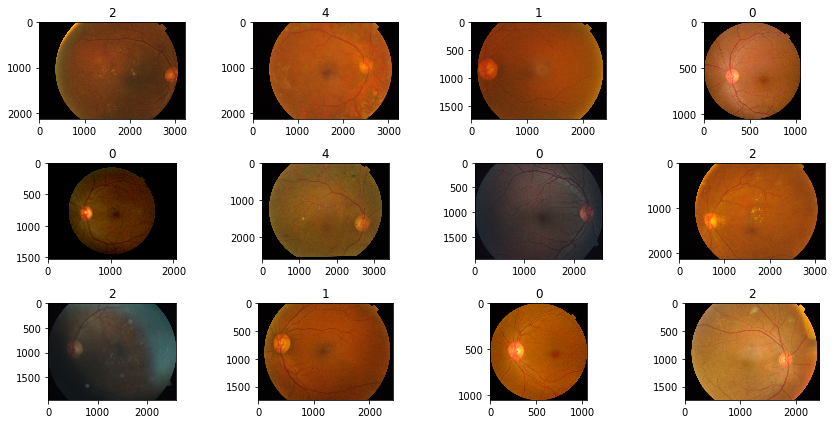

In [107]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(3*columns, 2*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'./drive/My Drive/Kaggle/APTOS/data/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [0]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [0]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

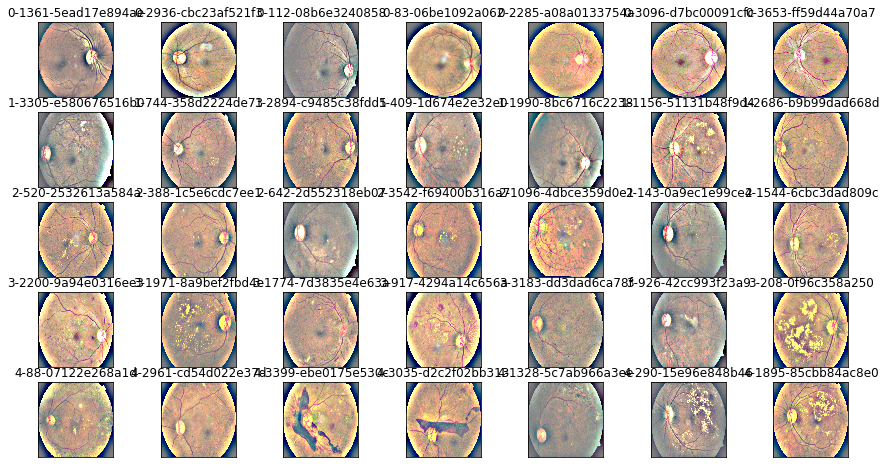

In [106]:
NUM_SAMP=7
fig = plt.figure(figsize=(15, 8))
for class_id in sorted(train_df['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=77).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"./drive/My Drive/Kaggle/APTOS/data/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [0]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'

In [0]:
test_df['id_code'] = test_df['id_code'].astype(str)+'.png'

In [79]:
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(5, random_state=77).iterrows()):
        image_path = train_df.loc[i,'id_code']
        image = cv2.imread(f'./drive/My Drive/Kaggle/APTOS/data/train_images/{image_path}.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')

error: ignored

<Figure size 1800x1152 with 0 Axes>

In [0]:
def preprocess_dataset(id_code, image_path, save_path, square_pad=True, circle_crop=True, blur=True, image_size=320):

    # load image
    image = cv2.imread(f"{image_path}/{id_code}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # remove extra black space
    if image.ndim == 2:
        mask = image > 7
        image = image[np.ix_(mask.any(1), mask.any(0))]
    elif image.ndim == 3:
        mask = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) > 7
        check_shape = image[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape != 0:
            image1=image[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            image2=image[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            image3=image[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            image = np.stack([image1,image2,image3],axis=-1)

    # scale radius
    scale = image_size
    x = image[int(image.shape[0]/2),:,:].sum(1)
    r = (x>x.mean() / 10).sum() / 2
    s = scale * 1.0/r
    image = cv2.resize(image, (0,0), fx=s, fy=s)

    # blur
    if blur:
        image = Image.fromarray(image.astype(np.uint8))
        image = np.array(image, dtype=int) - \
                np.array(image.filter(ImageFilter.GaussianBlur(radius=scale/30)), dtype=int)
        image = np.clip(image*4+128, 0, 255)

    # pad
    if square_pad:
        max_dim = max(image.shape[0], image.shape[1])
        padder = albumentations.augmentations.transforms.PadIfNeeded(
            min_height=max_dim,
            min_width=max_dim,
            value=(128, 128, 128),
            border_mode=0,
            always_apply=True
        )
        image = padder(image=image)["image"]

    # circle crop
    if circle_crop:
        b = np.zeros(image.shape)
        cv2.circle(b, (image.shape[1]//2, image.shape[0]//2), int(scale*0.9), (1,1,1), -1, 8, 0)
        image = image*b + 128*(1-b)    

    # save
    image = cv2.resize(image.astype("uint8"), (image_size, image_size))
    np.save(f"{save_path}/{id_code}", image.astype(np.uint8))

In [0]:
preprocess_dataset(df.loc[i,'diagnosis'],df.loc[i,'id_code'],)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'training',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)
val_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'validation',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = None,
    x_col = 'id_code',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    directory = TEST_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [0]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
encoded_diagnosis = onehot_encoder.fit_transform(train_df[['diagnosis']])
print(encoded_diagnosis)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers import Dropout, GaussianNoise, GaussianDropout,GlobalAveragePooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers

In [0]:
from keras.applications.inception_v3 import InceptionV3
inet = InceptionV3(include_top = False, weights='imagenet', input_shape=(224,224,3))
model = Sequential()
model.add(inet)
# model.add(Conv2D(filters = 1024, kernel_size = (2,2),padding = 'same'))
# model.add(BatchNormalization())
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])

In [0]:
model.summary()

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)
# model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [0]:
history = model.fit_generator(generator=train_gen,              
                                    steps_per_epoch=len(train_gen)//BATCH_SIZE,
                                    validation_data=val_gen,                    
                                    validation_steps=len(val_gen)//BATCH_SIZE,
                                    epochs=50,
                                    callbacks = [early_stop], 
                                    use_multiprocessing = True,
                                    verbose=1)

In [0]:
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

In [0]:
loss, acc = model.evaluate_generator(val_gen, steps=3, verbose=1)
print("Loss of the model: ",loss)
print("Accuracy of the model: ",acc)

In [0]:
acc, val_acc = history.history['acc'], history.history['val_acc']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))
import matplotlib.pyplot as plt

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()